# HW 6

Miembros del grupo:
- 
- 
-

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Read data

In [22]:
df_train = pd.read_parquet("/Users/juan/Documents/Juan's MacBook Pro/CUNEF/Quinto/Credit Risk Analytics/data_solved/prosperLoanData_processed_train.parquet")
df_val = pd.read_parquet("/Users/juan/Documents/Juan's MacBook Pro/CUNEF/Quinto/Credit Risk Analytics/data_solved/prosperLoanData_processed_val.parquet")
df_oot = pd.read_parquet("/Users/juan/Documents/Juan's MacBook Pro/CUNEF/Quinto/Credit Risk Analytics/data_solved/prosperLoanData_processed_oot.parquet")

In [23]:
#drop indeterminates
df_train = df_train.loc[df_train.indeterm==False]
df_val = df_val.loc[df_val.indeterm==False]
df_oot = df_oot.loc[df_oot.indeterm==False]

In [24]:
#get the serialized data from previous session
import pickle
input_d2  = pickle.load(open("/Users/juan/Documents/Juan's MacBook Pro/CUNEF/Quinto/Credit Risk Analytics/data_solved/output_HW5.pkl", 'rb'))
corr_data, features = input_d2['corr_data'], input_d2['features']
df_iv, df_psi = input_d2['iv_df'], input_d2['psi_df']

## Filter out features

### Drop highly correlated features

In [25]:
corr_data

[('CreditScoreRangeLower',
  1,
  CreditScoreRangeUpper    1.0
  Name: CreditScoreRangeLower, dtype: float64),
 ('CreditScoreRangeUpper',
  1,
  CreditScoreRangeLower    1.0
  Name: CreditScoreRangeUpper, dtype: float64),
 ('CurrentCreditLines',
  2,
  OpenCreditLines          0.957426
  OpenRevolvingAccounts    0.853989
  Name: CurrentCreditLines, dtype: float64),
 ('OpenCreditLines',
  2,
  CurrentCreditLines       0.957426
  OpenRevolvingAccounts    0.888447
  Name: OpenCreditLines, dtype: float64),
 ('TotalCreditLinespast7years',
  1,
  TotalTrades    0.942083
  Name: TotalCreditLinespast7years, dtype: float64),
 ('OpenRevolvingAccounts',
  2,
  CurrentCreditLines    0.853989
  OpenCreditLines       0.888447
  Name: OpenRevolvingAccounts, dtype: float64),
 ('TotalTrades',
  1,
  TotalCreditLinespast7years    0.942083
  Name: TotalTrades, dtype: float64),
 ('TotalProsperPaymentsBilled',
  1,
  OnTimeProsperPayments    0.988512
  Name: TotalProsperPaymentsBilled, dtype: float64),
 ('

In [26]:
#run through the iv ranking, and drop features if they are correlated with any feature with better ranking
feats_sorted = df_iv.feature.values.tolist()

def get_uncorr_feats(corr_data, feats_sorted):
    """Handles the corr_data structure, to drop highlly correlated features
    
    Args:
        corr_data: List of tuples containing the correlation info
        feats_sorted: List, with the features to be sorted / dropped
        
    Returns:
        List with the features that have no correlation
    """
    features_keep = feats_sorted[:1]
    for feat in feats_sorted[1:]:
        #capture the correlation tuple
        crr_data = [crr for crr in corr_data if crr[0] == feat]
        if len(crr_data):
            #if there is a 'hit' with a feature in features_keep, do not include it
            hit = len(set(crr_data[0][2].index.tolist()) & set(features_keep)) > 0
            if hit:
                print ('Drop: ' + feat)
            else:
                features_keep.append(feat)    
        else:
            features_keep.append(feat)
    return features_keep

features_keep = get_uncorr_feats(corr_data, feats_sorted)

Drop: TotalProsperPaymentsBilled
Drop: CreditScoreRangeUpper
Drop: OpenCreditLines
Drop: OpenRevolvingAccounts
Drop: TotalCreditLinespast7years


In [27]:
len(features), len(features_keep), len(corr_data)

(45, 40, 9)

### Drop features with low IV

In [28]:
# IV filtering with this treshold
df_iv.head()

,feature,IV
29,IncomeRange,0.145180
31,StatedMonthlyIncome,0.119612
34,OnTimeProsperPayments,0.113475
28,DebtToIncomeRatio,0.111675
39,ScorexChangeAtTimeOfListing,0.108946


**TODO 1** Implementa una función que devuelva solo las columnas que tengan un IV inferior a un umbral dado. Usa el dataframe df_iv.

In [29]:
def lowIVFeatures(df_iv, th=0.02):
    """Returns a list with the features that have an IV lower that th
    
    Args:
        df_iv: Pandas Dataframe with the feature name and their corresponding IV
        th: Threshold to be considered when filtering the features
        
    Returns:
        List with features that have an IV lower than the threshold
    """
    # IMPLEMENT YOUR CODE HERE
    return df_iv.loc[df_iv["IV"]<th]["feature"]

In [30]:
# capture low IV features
low_iv_feats = lowIVFeatures(df_iv)
features_keep_iv = list(set(features_keep) - set(low_iv_feats))
len(features), len(features_keep), len(features_keep_iv)

(45, 40, 23)

### Drop unstable features

In [31]:
# PSI filtering with this treshold
df_psi.head()

,feature,PSI
42,Recommendations,0.000000e+00
21,PublicRecordsLast12Months,5.352324e-09
41,PercentFunded,2.141008e-08
20,PublicRecordsLast10Years,2.724033e-05
18,AmountDelinquent,7.428038e-05


**TODO 2** Implementa una función que devuelva solo las columnas que tengan un PSI mayor a un umbral dado. Usa el dataframe df_psi.

In [32]:
def highPSIFeatures(df_psi, TH_PSI=0.25):
    """Returns a list with the features that have a PSI higher that th
    
    Args:
        df_iv: Pandas Dataframe with the feature name and their corresponding IV
        th: Threshold to be considered when filtering the features
        
    Returns:
        List with features that have an IV lower than the threshold
    """
    # IMPLEMENT YOUR CODE HERE
    return df_psi.loc[df_psi["PSI"]>TH_PSI]["feature"]

In [33]:
# capture high (unstable) features
high_psi_features = highPSIFeatures(df_psi)
features_keep_psi = list(set(features_keep_iv) - set(high_psi_features))
len(features), len(features_keep), len(features_keep_iv), len(features_keep_psi)

(45, 40, 23, 21)

In [34]:
final_features = features_keep_psi
final_features

['TotalProsperLoans',
 'OnTimeProsperPayments',
 'IsBorrowerHomeowner',
 'TradesOpenedLast6Months',
 'Occupation',
 'StatedMonthlyIncome',
 'IncomeVerifiable',
 'CurrentlyInGroup',
 'ProsperPrincipalOutstanding',
 'ScorexChangeAtTimeOfListing',
 'DebtToIncomeRatio',
 'ProsperPaymentsLessThanOneMonthLate',
 'BorrowerState',
 'ProsperPrincipalBorrowed',
 'CurrentCreditLines',
 'IncomeRange',
 'InquiriesLast6Months',
 'TotalTrades',
 'AmountDelinquent',
 'ProsperPaymentsOneMonthPlusLate',
 'CreditScoreRangeLower']

## Preprocessing - Set up bucketing - "Trameado"

#### For numerical features

In [35]:
# features

In [36]:
def get_bucket_numfeature(df, feat_col, n_bins, input_slider=(0., 100.)):
    """Cuts a numeric feature in 'n_bins', balacing data in percentiles
    
    Args:
        df: Pandas DataFrame with the input data
        feat_col: Name of the column with the input feature
        obj_col: Name of the column with the target 
        n_bins: Number of cuts expected
        input_slider: Range considered for the bucketing
        
    Returns:
        List with the cuts corresponding to this feature
    """
    #get the numeric input from the dual slider
    # dividimos entre 100
    perc_sliders = [v/100. for v in input_slider]
    # calculamos los límites de la variable
    var_lims = df[feat_col].quantile([perc_sliders[0], perc_sliders[1]]).values
    v_min, v_max = var_lims[0], var_lims[1]
    #filter the dataset using the slider input
    df_cut = df.loc[(df[feat_col] <= v_max) & (df[feat_col] >= v_min)][[feat_col]]
    cuts = df_cut[feat_col].quantile(np.linspace(perc_sliders[0], perc_sliders[1], n_bins + 1)).values.tolist()
    cuts = sorted(list(set(cuts)))
    return cuts

def format_dummy_col(feat_col, dummy_col):
    """Handles column names for dummy data
    
    Args:
        feat_col: Name of the column with the input feature
        dummy_col: String of the dummy column 
        
    Returns:
        Dummy column with better formatting
    """
    out = dummy_col.replace("(", "")\
                   .replace("]", "")\
                   .replace(".0", "")\
                   .replace(", ", "|")
    
    return feat_col + '_' + out
    
def apply_bucketing_num(df, feat_col, cuts):
    """Applies bucketing to numerical feature
    
    Args:
        df: Pandas Dataframe with the input data
        feat_col: Name of the column with the input feature
        cuts: Cuts that will be applied to the input data
        
    Returns:
        Pandas dataframe with dummy columns
    """
    cut_col = '{}_cut'.format(feat_col)
    if len(cuts) == 2:
        cuts = [cuts[0], np.mean(cuts), cuts[1]]
    df[cut_col] = pd.cut(df[feat_col], cuts, include_lowest=True, precision=0)
    if df[cut_col].isna().any():
        df[cut_col] = df[cut_col].cat.add_categories(["NA"])
        df[cut_col] = df[cut_col].fillna("NA")
        
    dummies_df = pd.get_dummies(df[cut_col], drop_first=True)
    dummies_df.columns = [format_dummy_col(feat_col, str(col)) for col in dummies_df.columns.values.tolist()]
    
    return dummies_df

#### For categorical features

In [37]:
def get_bucket_catfeature(df, feat_col, n_bins):
    """Cuts a categorical feature in 'n_bins', keeping categories with highest volume
    
    Args:
        df: Pandas DataFrame with the input data
        feat_col: Name of the column with the input feature
        n_bins: Number of cuts expected
        
    Returns:
        List with the cuts corresponding to this feature
    """
    cuts = df.groupby(feat_col)[feat_col].count().sort_values(ascending=False)[:int(n_bins)].index.values.tolist()
    
    return cuts

def apply_bucketing_cat(df, feat_col, cuts):
    """Applies bucketing to categorical feature
    
    Args:
        df: Pandas Dataframe with the input data
        feat_col: Name of the column with the input feature
        cuts: Cuts that will be applied to the input data
        
    Returns:
        Pandas dataframe with dummy columns
    """
    cut_col = '{}_cut'.format(feat_col)
    df[cut_col] = df[feat_col]
    df.loc[~df[cut_col].isin(cuts), cut_col] = 'Other'
    if df[cut_col].isna().any():
        df[cut_col] = df[cut_col].fillna("NA")
        
    dummies_df = pd.get_dummies(df[cut_col], prefix=feat_col, drop_first=True)
    
    return dummies_df

In [38]:
#example of numerical bucketing
cuts_num = get_bucket_numfeature(df_train, 'CreditScoreRangeLower', 6)
dumm_num = apply_bucketing_num(df_train, 'CreditScoreRangeLower', cuts_num)
dumm_num[:10]

,CreditScoreRangeLower_640|680,CreditScoreRangeLower_680|700,CreditScoreRangeLower_700|720,CreditScoreRangeLower_720|760,CreditScoreRangeLower_760|880
0,1,0,0,0,0
2,1,0,0,0,0
3,0,1,0,0,0
4,0,1,0,0,0
5,0,0,0,0,1
6,0,0,0,0,0
7,0,0,1,0,0
8,0,0,0,1,0
9,0,0,0,0,1
10,0,0,0,0,0


In [39]:
#example of categorical bucketing
cuts_cat = get_bucket_catfeature(df_train, 'Occupation', 6)
dumm_cat = apply_bucketing_cat(df_train, 'Occupation', cuts_cat)
dumm_cat[:10]

,Occupation_Analyst,Occupation_Computer Programmer,Occupation_Executive,Occupation_Other,Occupation_Professional
0,0,0,0,1,0
2,0,0,0,1,0
3,0,0,0,1,0
4,0,0,0,1,0
5,0,0,0,0,1
6,0,0,0,0,1
7,0,0,0,1,0
8,0,0,0,1,0
9,0,0,0,1,0
10,0,0,0,1,0


### Set up bucketing, then apply it

In [40]:
def get_bucket_feature(df, feat_col, n_bins=6):
    """Trains bucketing in a feature, whether if it is numerical
    or categorical
    
    Args:
        df: Pandas Dataframe with the input data
        feat_col: Name of the column with the input feature
        n_bins: Cuts that will be applied to the input data
        
    Returns:
        List with the cuts learned from the data
    """
    if df[feat_col].dtypes in (object, bool):
        cuts = get_bucket_catfeature(df, feat_col, n_bins)
    else:
        cuts = get_bucket_numfeature(df, feat_col, n_bins)
    return cuts

def get_bucketing_allfeatures(df, features, n_bins=6):
    """Trains bucketing in all given features of a dataset
    
    Args:
        df: Pandas Dataframe with the input data
        features: Features which bucketing will be learnt
        n_bins: Cuts that will be applied to the input data
        
    Returns:
        Dict, containing all features and its corresponding
        bucketing. For example:
         {'feature1': cuts1,
          'feature2': cuts2}  
    """
    out_dict = {}
    for feature in features:
        print(feature)
        cuts = get_bucket_feature(df, feature, n_bins)
        out_dict[feature] = cuts
    return out_dict

In [41]:
dict_bucketing = get_bucketing_allfeatures(df_train, final_features, n_bins=4)
dict_bucketing

TotalProsperLoans
OnTimeProsperPayments
IsBorrowerHomeowner
TradesOpenedLast6Months
Occupation
StatedMonthlyIncome
IncomeVerifiable
CurrentlyInGroup
ProsperPrincipalOutstanding
ScorexChangeAtTimeOfListing
DebtToIncomeRatio
ProsperPaymentsLessThanOneMonthLate
BorrowerState
ProsperPrincipalBorrowed
CurrentCreditLines
IncomeRange
InquiriesLast6Months
TotalTrades
AmountDelinquent
ProsperPaymentsOneMonthPlusLate
CreditScoreRangeLower


{'TotalProsperLoans': [0.0, 1.0, 2.0, 7.0],
 'OnTimeProsperPayments': [0.0, 10.0, 19.0, 34.0, 103.0],
 'IsBorrowerHomeowner': [True, False],
 'TradesOpenedLast6Months': [0.0, 1.0, 20.0],
 'Occupation': ['Other', 'Professional', 'Computer Programmer', 'Executive'],
 'StatedMonthlyIncome': [0.0,
  3166.666667,
  4666.666667,
  6833.333333,
  483333.333333],
 'IncomeVerifiable': [True, False],
 'CurrentlyInGroup': [False, True],
 'ProsperPrincipalOutstanding': [0.0, 817.575, 3049.0924999999997, 21523.79],
 'ScorexChangeAtTimeOfListing': [-209.0, -32.0, -3.0, 30.0, 257.0],
 'DebtToIncomeRatio': [0.0, 0.13, 0.19, 0.29, 10.01],
 'ProsperPaymentsLessThanOneMonthLate': [0.0, 28.0],
 'BorrowerState': ['CA', 'FL', 'NY', 'TX'],
 'ProsperPrincipalBorrowed': [0.0, 3000.0, 5000.0, 9000.0, 57499.0],
 'CurrentCreditLines': [0.0, 6.0, 9.0, 12.0, 38.0],
 'IncomeRange': ['$25,000-49,999',
  '$50,000-74,999',
  '$100,000+',
  '$75,000-99,999'],
 'InquiriesLast6Months': [0.0, 1.0, 2.0, 27.0],
 'TotalTrades

In [42]:
len(final_features), len(dict_bucketing.keys())

(21, 21)

In [43]:
def apply_bucketing(df, feat_col, cuts):
    """Applies a bucketing schema
    
    Args:
        df: Pandas Dataframe with the input data
        feat_col: Name of the column with the input feature
        cuts: Cuts that will be applied to the input data
        
    Returns:
        Pandas DataFrame with columns dummy columns
    """
    if df[feat_col].dtypes in (object, bool):
        df_buck = apply_bucketing_cat(df, feat_col, cuts)
    else:
        df_buck = apply_bucketing_num(df, feat_col, cuts)
    return df_buck

In [44]:
apply_bucketing(df_train, 'CreditScoreRangeLower', dict_bucketing['CreditScoreRangeLower']).head()

,CreditScoreRangeLower_660|700,CreditScoreRangeLower_700|740,CreditScoreRangeLower_740|880
0,0,0,0
2,0,0,0
3,1,0,0
4,1,0,0
5,0,0,1


In [45]:
# Apply the bucketing

# Keep each column dummy columns in independent lists
list_df_tr, list_df_val, list_df_oot = [], [], []
for feat in final_features:
    list_df_tr.append(apply_bucketing(df_train, feat, dict_bucketing[feat]))
    list_df_val.append(apply_bucketing(df_val, feat, dict_bucketing[feat]))
    list_df_oot.append(apply_bucketing(df_oot, feat, dict_bucketing[feat]))

# Then 'vertically' combine them
df_tr_preproc = pd.concat(list_df_tr, axis=1)
df_val_preproc = pd.concat(list_df_val, axis=1)
df_oot_preproc = pd.concat(list_df_oot, axis=1)

# Capture the name of all buckets in our dataset
keep_cols_buck = df_tr_preproc.columns

In [46]:
df_tr_preproc.shape, df_oot_preproc.shape

((15259, 56), (13220, 58))

In [47]:
# Capture the target in each subset
y_tr, y_val, y_oot = df_train['bad'], df_val['bad'], df_oot['bad']

## Modeling

### Logistic Regression

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [49]:
def get_auc(y_true, y_pred):
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
    return metrics.auc(fpr, tpr)

In [50]:
#check buckets correlations
corr = df_tr_preproc[keep_cols_buck].corr()
orig_features = keep_cols_buck.values.tolist()
corr_TH = 0.75
n_corr_list=[]
corr_feats_list=[]
for f in orig_features:
    #get correlation entries for the feature
    corr_f = corr[f][[col for col in orig_features if col!=f]]
    #work with absolute value
    corr_f_abs = corr_f.abs()
    #get features above corr TH
    corr_ht_th = corr_f_abs[corr_f_abs>corr_TH]
    n_corr_list.append(corr_ht_th.shape[0])
    corr_feats_list.append(corr_ht_th)

corr_buckets = [(feat, n, feats_corr) for n, feats_corr, feat in zip(n_corr_list, corr_feats_list, orig_features) if n>0]
corr_buckets

[('TotalProsperLoans_NA',
  6,
  OnTimeProsperPayments_NA                  1.000000
  ProsperPrincipalOutstanding_NA            1.000000
  ScorexChangeAtTimeOfListing_NA            0.996584
  ProsperPaymentsLessThanOneMonthLate_NA    1.000000
  ProsperPrincipalBorrowed_NA               1.000000
  ProsperPaymentsOneMonthPlusLate_NA        1.000000
  Name: TotalProsperLoans_NA, dtype: float64),
 ('OnTimeProsperPayments_NA',
  6,
  TotalProsperLoans_NA                      1.000000
  ProsperPrincipalOutstanding_NA            1.000000
  ScorexChangeAtTimeOfListing_NA            0.996584
  ProsperPaymentsLessThanOneMonthLate_NA    1.000000
  ProsperPrincipalBorrowed_NA               1.000000
  ProsperPaymentsOneMonthPlusLate_NA        1.000000
  Name: OnTimeProsperPayments_NA, dtype: float64),
 ('IncomeVerifiable_True',
  1,
  DebtToIncomeRatio_NA    0.999027
  Name: IncomeVerifiable_True, dtype: float64),
 ('ProsperPrincipalOutstanding_NA',
  6,
  TotalProsperLoans_NA                      

In [51]:
glm_cols = get_uncorr_feats(corr_buckets, orig_features)

Drop: OnTimeProsperPayments_NA
Drop: ProsperPrincipalOutstanding_NA
Drop: ScorexChangeAtTimeOfListing_NA
Drop: DebtToIncomeRatio_NA
Drop: ProsperPaymentsLessThanOneMonthLate_NA
Drop: ProsperPrincipalBorrowed_NA
Drop: ProsperPaymentsOneMonthPlusLate_NA


In [52]:
glm_cols

['TotalProsperLoans_1|2',
 'TotalProsperLoans_2|7',
 'TotalProsperLoans_NA',
 'OnTimeProsperPayments_10|19',
 'OnTimeProsperPayments_19|34',
 'OnTimeProsperPayments_34|103',
 'IsBorrowerHomeowner_True',
 'TradesOpenedLast6Months_1|20',
 'Occupation_Executive',
 'Occupation_Other',
 'Occupation_Professional',
 'StatedMonthlyIncome_3167|4667',
 'StatedMonthlyIncome_4667|6833',
 'StatedMonthlyIncome_6833|483333',
 'IncomeVerifiable_True',
 'CurrentlyInGroup_True',
 'ProsperPrincipalOutstanding_818|3049',
 'ProsperPrincipalOutstanding_3049|21524',
 'ScorexChangeAtTimeOfListing_-32|-3',
 'ScorexChangeAtTimeOfListing_-3|30',
 'ScorexChangeAtTimeOfListing_30|257',
 'DebtToIncomeRatio_0.1|0.2',
 'DebtToIncomeRatio_0.2|0.3',
 'DebtToIncomeRatio_0.3|10',
 'ProsperPaymentsLessThanOneMonthLate_14|28',
 'BorrowerState_FL',
 'BorrowerState_NY',
 'BorrowerState_Other',
 'BorrowerState_TX',
 'ProsperPrincipalBorrowed_3000|5000',
 'ProsperPrincipalBorrowed_5000|9000',
 'ProsperPrincipalBorrowed_9000|57

In [53]:
#train first model
lr = LogisticRegression(solver='lbfgs', C=0.01)
lr.fit(df_tr_preproc[glm_cols], y_tr)

LogisticRegression(C=0.01)

In [54]:
df_tr_preproc[glm_cols].head()

,TotalProsperLoans_1|2,TotalProsperLoans_2|7,TotalProsperLoans_NA,OnTimeProsperPayments_10|19,OnTimeProsperPayments_19|34,OnTimeProsperPayments_34|103,IsBorrowerHomeowner_True,TradesOpenedLast6Months_1|20,Occupation_Executive,Occupation_Other,...,InquiriesLast6Months_1|2,InquiriesLast6Months_2|27,TotalTrades_14|21,TotalTrades_21|30,TotalTrades_30|110,AmountDelinquent_124604|249209,ProsperPaymentsOneMonthPlusLate_10|21,CreditScoreRangeLower_660|700,CreditScoreRangeLower_700|740,CreditScoreRangeLower_740|880
0,0,0,1,0,0,0,1,0,0,1,...,1,0,1,0,0,0,0,0,0,0
2,0,0,0,1,0,0,1,0,0,1,...,0,0,1,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,1,0,1,...,0,0,0,1,0,0,0,1,0,0
4,0,0,1,0,0,0,1,0,0,1,...,0,0,1,0,0,0,0,1,0,0
5,0,0,1,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [55]:
# Predict for all subsets
pred_log1_tr = lr.predict_proba(df_tr_preproc[glm_cols])[:, 1]
pred_log1_val = lr.predict_proba(df_val_preproc[glm_cols])[:, 1]
pred_log1_oot = lr.predict_proba(df_oot_preproc[glm_cols])[:, 1]

In [56]:
Log1_aucs = get_auc(y_tr, pred_log1_tr), get_auc(y_val, pred_log1_val), get_auc(y_oot, pred_log1_oot)
Log1_aucs

(0.7177330452450146, 0.6992755722978846, 0.6902114922516076)

In [57]:
# Get p-values
# Mostly from: https://gist.github.com/rspeare/77061e6e317896be29c6de9a85db301d

import scipy.stats as stat
def get_p_vals(lr, X):
    denom = (2.0*(1.0+np.cosh(lr.decision_function(X))))
    denom = np.tile(denom,(X.shape[1],1)).T
    F_ij = np.dot((X/denom).T,X) ## Fisher Information Matrix
    Cramer_Rao = np.linalg.inv(F_ij) ## Inverse Information Matrix
    sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
    z_scores = lr.coef_[0]/sigma_estimates # z-score for eaach model coefficient
    p_values = [stat.norm.sf(abs(x))*2 for x in z_scores] ### two tailed test for p-values#        
    return p_values

def show_lr_summary(p_values, features, lr):
    df_ret = pd.DataFrame({'feature': features,
                           'p_val': p_values,
                           'betas': lr.coef_.tolist()[0]})[['feature', 'betas', 'p_val']]
    return df_ret

In [58]:
# If there was any issue with the data (high correlations...)
# This would be messy, with NAs, or maybe not even able to run
p_values = get_p_vals(lr, df_tr_preproc[glm_cols])
show_lr_summary(p_values, glm_cols, lr)

,feature,betas,p_val
0,TotalProsperLoans_1|2,-0.073837,0.718769
1,TotalProsperLoans_2|7,-0.077556,0.813193
2,TotalProsperLoans_NA,0.219102,0.205575
3,OnTimeProsperPayments_10|19,-0.215860,0.226097
4,OnTimeProsperPayments_19|34,-0.137822,0.461044
5,OnTimeProsperPayments_34|103,-0.175573,0.444598
6,IsBorrowerHomeowner_True,-0.040066,0.590019
7,TradesOpenedLast6Months_1|20,0.279568,0.000881
8,Occupation_Executive,-0.057105,0.820037
9,Occupation_Other,0.113346,0.478394


#### P-value based feature selection

In [59]:
# remove each bucket with the highest p-value N times
# assess how the AUC changes
N_iterations = len(glm_cols) - 3
glm_cols_pvals = [c for c in glm_cols]

# keep the AUCs in each interation 
auc_train, auc_val, auc_oot = [], [], []
# List of tuples where all selected features status will 
# be stored per iteration
features_it_pval = []

# for each iteration
for it in range(N_iterations):
    #capture the feature to be dropped
    #in the first iteration we are using the p_values from the model trained 'outside'
    feat_drop = [feat for feat, p in zip(glm_cols_pvals, p_values) if p == max(p_values)][0]
    glm_cols_pvals.remove(feat_drop)
    #re-train the model
    lr_it = LogisticRegression(solver='lbfgs', C=0.01)
    lr_it.fit(df_tr_preproc[glm_cols_pvals], y_tr)
    # Predict for all subsets
    pred_tr = lr_it.predict_proba(df_tr_preproc[glm_cols_pvals])[:, 1]
    pred_val = lr_it.predict_proba(df_val_preproc[glm_cols_pvals])[:, 1]
    pred_oot = lr_it.predict_proba(df_oot_preproc[glm_cols_pvals])[:, 1]
    #get aucs
    auc_train.append(get_auc(y_tr, pred_tr))
    auc_val.append(get_auc(y_val, pred_val)) 
    auc_oot.append(get_auc(y_oot, pred_oot))
    #get p-values
    p_values = get_p_vals(lr_it, df_tr_preproc[glm_cols_pvals])
    #keep features status at iteration
    features_it_pval.append((it, [c for c in glm_cols_pvals]))

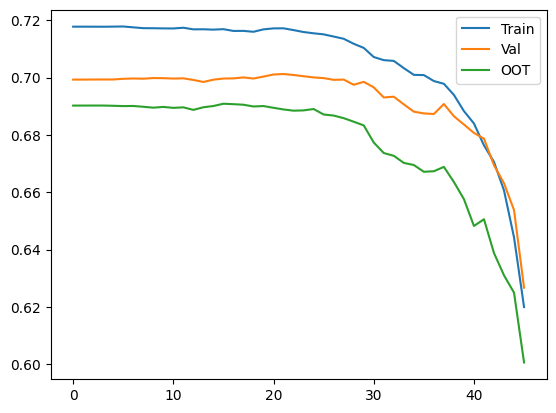

In [60]:
# Plot AUCs in each iteration
iterations = [i for i in range(N_iterations)]
plt.plot(iterations, auc_train, label='Train')
plt.plot(iterations, auc_val, label='Val')
plt.plot(iterations, auc_oot, label='OOT')
plt.legend()

In [61]:
# At iteration 40 more or less it stays stable
final_features_bucketing = [feats for it, feats in features_it_pval if it==26][0]
# Train the final model with the interesting buckets
lr_final = LogisticRegression(solver='lbfgs', C=0.01)
lr_final.fit(df_tr_preproc[final_features_bucketing], y_tr)

LogisticRegression(C=0.01)

In [62]:
# Predict for all subsets
pred_tr = lr_final.predict_proba(df_tr_preproc[final_features_bucketing])[:, 1]
pred_val = lr_final.predict_proba(df_val_preproc[final_features_bucketing])[:, 1]
pred_oot = lr_final.predict_proba(df_oot_preproc[final_features_bucketing])[:, 1]

Log2_aucs = get_auc(y_tr, pred_tr), get_auc(y_val, pred_val), get_auc(y_oot, pred_oot)

In [63]:
p_values = get_p_vals(lr_final, df_tr_preproc[final_features_bucketing])
show_lr_summary(p_values, final_features_bucketing, lr_final)

,feature,betas,p_val
0,TotalProsperLoans_NA,0.268849,0.009795
1,OnTimeProsperPayments_10|19,-0.217184,0.190479
2,OnTimeProsperPayments_19|34,-0.148382,0.370631
3,OnTimeProsperPayments_34|103,-0.208319,0.209454
4,TradesOpenedLast6Months_1|20,0.277597,0.000884
5,Occupation_Other,0.124132,0.137118
6,StatedMonthlyIncome_6833|483333,-0.341570,0.000551
7,IncomeVerifiable_True,-0.349414,0.000112
8,ProsperPrincipalOutstanding_3049|21524,0.176892,0.200695
9,ScorexChangeAtTimeOfListing_-3|30,-0.207342,0.192185


#### AUC based feature selection

In [64]:
# Try to remove all available features.
# Remove the feature that has the lowest impact in AUC
N_iterations = len(glm_cols) - 3
glm_cols_auc = [c for c in glm_cols]

auc_train, auc_val, auc_oot = [], [], []
features_it_auc = []
for it in range(N_iterations):
    print('Working for iteration: {}'.format(str(it)))
    #re-train the model
    lr_it = LogisticRegression(solver='lbfgs', C=0.01)
    lr_it.fit(df_tr_preproc[glm_cols_auc], y_tr)
    # Predict for all subsets
    pred_tr = lr_it.predict_proba(df_tr_preproc[glm_cols_auc])[:, 1]
    pred_val = lr_it.predict_proba(df_val_preproc[glm_cols_auc])[:, 1]
    pred_oot = lr_it.predict_proba(df_oot_preproc[glm_cols_auc])[:, 1]
    #get base aucs
    auc_train_it, auc_val_it, auc_oot_it = get_auc(y_tr, pred_tr), get_auc(y_val, pred_val), get_auc(y_oot, pred_oot)
    auc_train.append(auc_train_it)
    auc_val.append(auc_val_it) 
    auc_oot.append(auc_oot_it)
    #set up minimum gap
    min_gap = 500
    for feat_eval in glm_cols_auc:
        #use validation AUC only as evaluation metric
        #keep features in iteration it, but the feature under evaluation
        glm_cols_auc_ev = [c for c in glm_cols_auc if c!=feat_eval]
        lr_it_ev = LogisticRegression(solver='lbfgs', C=0.01)
        lr_it_ev.fit(df_tr_preproc[glm_cols_auc_ev], y_tr)
        #predit @ val data
        pred_val = lr_it_ev.predict_proba(df_val_preproc[glm_cols_auc_ev])[:, 1]
        #get auc @ val
        auc_val_it_ev = get_auc(y_val, pred_val)
        #check gap
        gap_val_auc = auc_val_it - auc_val_it_ev
        #capture the feature that has the lowest AUC impact
        if gap_val_auc < min_gap:
            candidate_drop = feat_eval
            min_gap = gap_val_auc
    #remove from the feature set the selected feature
    glm_cols_auc.remove(candidate_drop)
    #keep features status at iteration
    features_it_auc.append((it, [c for c in glm_cols_auc]))

Working for iteration: 0
Working for iteration: 1
Working for iteration: 2
Working for iteration: 3
Working for iteration: 4
Working for iteration: 5
Working for iteration: 6
Working for iteration: 7
Working for iteration: 8
Working for iteration: 9
Working for iteration: 10
Working for iteration: 11
Working for iteration: 12
Working for iteration: 13
Working for iteration: 14
Working for iteration: 15
Working for iteration: 16
Working for iteration: 17
Working for iteration: 18
Working for iteration: 19
Working for iteration: 20
Working for iteration: 21
Working for iteration: 22
Working for iteration: 23
Working for iteration: 24
Working for iteration: 25
Working for iteration: 26
Working for iteration: 27
Working for iteration: 28
Working for iteration: 29
Working for iteration: 30
Working for iteration: 31
Working for iteration: 32
Working for iteration: 33
Working for iteration: 34
Working for iteration: 35
Working for iteration: 36
Working for iteration: 37
Working for iteration:

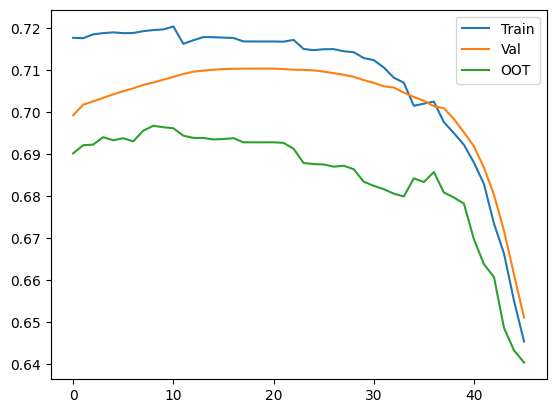

In [65]:
# Plot AUCs in each iteration
iterations = [i for i in range(N_iterations)]
plt.plot(iterations, auc_train, label='Train')
plt.plot(iterations, auc_val, label='Val')
plt.plot(iterations, auc_oot, label='OOT')
plt.legend()

In [66]:
# get the iteration where it stays stable
final_features_bucketing_auc = [feats for it, feats in features_it_auc if it==26][0]
# Train the final model with the interesting buckets
lr_final_auc = LogisticRegression(solver='lbfgs', C=0.01)
lr_final_auc.fit(df_tr_preproc[final_features_bucketing_auc], y_tr)

LogisticRegression(C=0.01)

In [67]:
# Predict for all subsets
pred_tr = lr_final_auc.predict_proba(df_tr_preproc[final_features_bucketing_auc])[:, 1]
pred_val = lr_final_auc.predict_proba(df_val_preproc[final_features_bucketing_auc])[:, 1]
pred_oot = lr_final_auc.predict_proba(df_oot_preproc[final_features_bucketing_auc])[:, 1]

Log3_aucs = get_auc(y_tr, pred_tr), get_auc(y_val, pred_val), get_auc(y_oot, pred_oot)

#### Gain Table

**TODO3** Implementa una función que te calcule una gain table, con una fila for bucket de scores, y con las siguientes columnas:
 - avg_pred: El score medio en ese bucket
 - BR: La tasa de malos en ese bucket
 - N_bads: El número de malos en ese bucket
 - N: El número de muestras en ese bucket
 - N_goods: El número de buenos en ese bucket
 - pct_bad_acum: El porcentaje de malos acumulados en ese bucket
 - pct_approv_acum: El porcentae de aprobación hasta ese bucket
 
La tabla estará ordenada de scores más bajos (mejor perfil), a scores más altos (peor perfil)

In [ ]:
# Tabla de eficiencia / Gain table
def get_gain_table(pred, df, col_target='bad', n_buckets=10):
    """Generate the gain table given a population, and its predictions
    
    Args:
        pred: np.array / pd.Series containing predictions
        df: Pandas DataFrame containing the population to be assesed
        col_target: Name of the target column
        n_buckets: Number of buckets for the gain table
        
    Returns:
        Pandas DataFrame representing the gain table
    """
    df['pred'] = pred
    pred_cuts = df['pred'].quantile(np.linspace(0, 1, num = n_buckets + 1))
    df['pred_cut'] = # Use the pd.cut() function

In [ ]:
# usa la función get_gain_table en el conjunto oot
get_gain_table(pred_oot, df_oot)

**TODO 4** Comenta la gain table anterior (sobre el conjunto OOT). ¿Qué conclusiones podemos sacar con respecto al funcionamiento del modelo? 

Introduce tu comentario aquí.

In [ ]:
# gain table for training sample
get_gain_table(pred_tr, df_train)

### Random Forest

In [ ]:
# Lighther preprocessing
# Handle NAs @ numeric features
# fill with a value lower than its minimum
# We can reuse previopus categorical preprocessing

dtypes = df_train[final_features].dtypes
cat_features = df_train[features].select_dtypes(include=["bool", "object"]).columns.tolist()
num_feats = [f for f in final_features if f not in cat_features]

def get_nafill_rf_num(df, num_features, gap_min=1e6):
    """Get a dictionary, that will store the value that will be used 
    to fill NAs in numeric data.
    
    Args:
        df: Pandas Dataframe with the input data
        num_features: List with the names of categorical features
        gap_min: Gap between minimum value and filling value
        
    Returns:
        Dictionary, with the following structure:
        {feature1: fill_val1,
         feature2: fill_val2}
    """
    dict_fill = {}
    for num_feat in num_features:
        dict_fill[num_feat] = df[num_feat].min() - gap_min
    return dict_fill
    

def apply_nafill_rf_num(df, dict_fillrf):
    """Given a dictionary with the values to be used in NA filling,
    use it to fill NAs.
    
    Args:
        df: Pandas Dataframe with the input data
        dict_fillrf: Dictionary, that stores filling values
        
    Returns:
        Pandas Dataframe with NA being filled
    """
    df_out = df.copy()
    for num_feat in dict_fillrf.keys():
        df_out.loc[df_out[num_feat].isna(), num_feat] = dict_fillrf[num_feat]
    return df_out

In [ ]:
#get dictionary to fill values from train
dict_nafill = get_nafill_rf_num(df_train, num_feats)
#apply it to train, val and oot
df_train_fill = apply_nafill_rf_num(df_train, dict_nafill)
df_val_fill = apply_nafill_rf_num(df_val, dict_nafill)
df_oot_fill = apply_nafill_rf_num(df_oot, dict_nafill)

In [ ]:
# Keep each column dummy columns in independednt lists
# Initialize with the numeric data already filled
list_df_tr, list_df_val, list_df_oot = [df_train_fill[num_feats]], [df_val_fill[num_feats]], [df_oot_fill[num_feats]]
# Add the bucketing results of categorical data
for feat in cat_features:
    list_df_tr.append(apply_bucketing(df_train, feat, dict_bucketing[feat]))
    list_df_val.append(apply_bucketing(df_val, feat, dict_bucketing[feat]))
    list_df_oot.append(apply_bucketing(df_oot, feat, dict_bucketing[feat]))

# Then combine them column-wise
df_tr_preproc_rf = pd.concat(list_df_tr, axis=1)
df_val_preproc_rf = pd.concat(list_df_val, axis=1)
df_oot_preproc_rf = pd.concat(list_df_oot, axis=1)

# Keep the final column names
keep_cols_rf = df_tr_preproc_rf.columns

**TODO 5** Entrena un RandomForestClassifier, y evalua su rendimiento (AUC, gain table). Revisa la documentación del modelo, y elige parámetros razonables

In [ ]:
# Train a RF-Classifier
from sklearn.ensemble import RandomForestClassifier

X_tr = df_tr_preproc_rf[keep_cols_rf]
X_val = df_val_preproc_rf[keep_cols_rf]
X_oot = df_oot_preproc_rf[keep_cols_rf]

# Train your model
rf = # rf is the RandomForestClassifier object you will work with

# Predict for all subsets
pred_rf_tr = #
pred_rf_val = # 
pred_rf_oot = #

# Get AUC metrics in all subsets
                       
# Compute the gain table for the OOT set
rf_aucs = ...

In [ ]:
# Show Feature importance
imp_df = pd.DataFrame({'feature': keep_cols_rf,
                       'importance': rf.feature_importances_})
imp_df.sort_values(by='importance', ascending=False)

**TODO 6** Entrena un XGBClassifier, y evalua su rendimiento (AUC, gain table). Revisa la documentación del modelo y elige parámetros razonables https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier

### XGBoost

In [ ]:
# Train a XGBClassifier
from xgboost import XGBClassifier

# Train your model
xgb = # xgb is the RandomForestClassifier object you will work with

# Predict for all subsets
pred_xgb_tr = #
pred_xgb_val = # 
pred_xgb_oot = #
# Get AUC metrics in all subsets
                       
                          
# Compute the gain table for the OOT set
xgb_aucs = # ...

In [ ]:
# Sow feature importance
imp_df = pd.DataFrame({'feature': keep_cols_rf,
                       'importance': xgb.feature_importances_})
imp_df.sort_values(by='importance', ascending=False)

## Compare model performances

In [ ]:
df_aucs = pd.DataFrame([Log1_aucs, Log2_aucs, Log3_aucs, rf_aucs, xgb_aucs])
df_aucs.columns = ["AUC_Train", "AUC_Val", "AUC_OOT"]
df_aucs.index = ["Logistic", "Log_Pval", "Log_AUC", "RF", "XGBoost"]
df_aucs

**TODO 7** Comenta el rendimiento de los modelos. ¿Qué modelo moverias a producción? 